<a href="https://colab.research.google.com/github/doogzultz/time_series_project/blob/main/model_test_simple_and_classical.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import pandas as pd
import numpy as np
import tensorflow as tf
from pandas.plotting import scatter_matrix
from tensorflow.keras.layers import Layer, Dense, Dropout, Input, \
Flatten, Concatenate, Conv1D, LSTM, Bidirectional, BatchNormalization, Activation, TimeDistributed, Lambda, MaxPooling1D
from tensorflow.keras.models import Model
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.utils import shuffle
from sklearn.compose import ColumnTransformer
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import os
from sklearn.utils import shuffle

In [4]:
class g:
  window_size = 0
  batch_size = 16
  valid_size = .1
  test_size = .1
  test = False

In [5]:
url = "https://raw.githubusercontent.com/doogzultz/time_series_project/main/data.csv"
data = pd.read_csv(url)

In [6]:
data.columns

Index(['date', 'identifier', 'market_cap', 'sector', 'index_membership',
       'factor_1', 'factor_2', 'factor_3', 'factor_4', 'factor_5', 'factor_6',
       'factor_7', 'factor_8', 'factor_9', 'factor_10', 'target'],
      dtype='object')

In [7]:
data.drop(columns = 'index_membership', inplace = True)

In [8]:
data.sort_values(by = ['identifier', 'date'], inplace = True)
data

,date,identifier,market_cap,sector,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,factor_8,factor_9,factor_10,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,35,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,0.792736,-0.000005,0.109029,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,35,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,0.333230,-0.009504,0.121348,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,35,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,0.058918,-0.000099,0.890898,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,35,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,0.699718,-0.000037,0.355059,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,35,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,0.961276,0.000163,0.196711,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,25,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,0.308049,0.012255,0.281193,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,25,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,0.559633,0.001058,0.755124,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,25,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,0.591153,0.000054,0.933679,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,25,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,0.373209,-0.000411,0.225972,-0.000242


In [9]:
(data== 0).sum(axis=0)

date           0
identifier     0
market_cap     0
sector         0
factor_1       0
factor_2      68
factor_3       0
factor_4       0
factor_5       0
factor_6       0
factor_7       0
factor_8       0
factor_9      68
factor_10      0
target        68
dtype: int64

In [10]:
ident_counts= data.value_counts('identifier')
ident_counts

identifier
AD41WBQFVG43    104
UZ4DWDZ8ALZ4    104
KR47536Y10D4    104
KPJ8FTV9ESJ3    104
KMHQ727PU8E2    104
               ... 
PNUM57CYEB27      5
KHKNKSMXBWP3      5
LYCPQJ19AOY0      5
RENR64FT3I74      5
LALJLSN9UMP2      2
Length: 356, dtype: int64

In [11]:
data.value_counts('sector', normalize = True).sort_index()

sector
10    0.049221
15    0.093162
20    0.208527
25    0.132849
30    0.072759
35    0.049003
40    0.232812
45    0.051674
50    0.038352
55    0.071642
dtype: float64

In [12]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values > 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.052423
15    0.093655
20    0.212044
25    0.126521
30    0.076618
35    0.045433
40    0.228443
45    0.052423
50    0.039048
55    0.073392
dtype: float64

In [13]:
data[data['identifier'].isin(list(ident_counts[ident_counts.values <= 80].index))].value_counts('sector', normalize = True).sort_index()

sector
10    0.010229
15    0.087152
20    0.165712
25    0.209902
30    0.025777
35    0.092471
40    0.286007
45    0.042553
50    0.029869
55    0.050327
dtype: float64

In [14]:
sector_onehot = pd.get_dummies(data['sector'], prefix='sector')
sector_onehot

,sector_10,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55
82,0,0,0,0,0,1,0,0,0,0
400,0,0,0,0,0,1,0,0,0,0
718,0,0,0,0,0,1,0,0,0,0
1036,0,0,0,0,0,1,0,0,0,0
1354,0,0,0,0,0,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
12552,0,0,0,1,0,0,0,0,0,0
12862,0,0,0,1,0,0,0,0,0,0
13172,0,0,0,1,0,0,0,0,0,0
13483,0,0,0,1,0,0,0,0,0,0


In [15]:
target = data['target']
data.drop(columns = ['sector', 'target'], inplace = True)
data = pd.concat([data, sector_onehot, target], axis = 1)
data

,date,identifier,market_cap,factor_1,factor_2,factor_3,factor_4,factor_5,factor_6,factor_7,...,sector_15,sector_20,sector_25,sector_30,sector_35,sector_40,sector_45,sector_50,sector_55,target
82,2010-01-06,AD41WBQFVG43,5.843968e+10,0.766639,-0.000032,0.832677,0.500608,0.193489,0.246089,0.753702,...,0,0,0,0,1,0,0,0,0,-0.000006
400,2010-01-13,AD41WBQFVG43,4.758865e+10,0.907349,-0.022933,0.346457,0.581694,0.648483,0.872304,0.723412,...,0,0,0,0,1,0,0,0,0,-0.008721
718,2010-01-20,AD41WBQFVG43,3.374757e+10,0.476465,-0.000114,0.592328,0.379747,0.810961,0.017737,0.619208,...,0,0,0,0,1,0,0,0,0,-0.000081
1036,2010-01-27,AD41WBQFVG43,4.908395e+10,0.265141,-0.000034,0.521405,0.682492,0.547349,0.155915,0.068966,...,0,0,0,0,1,0,0,0,0,-0.000018
1354,2010-02-03,AD41WBQFVG43,2.729189e+10,0.423987,0.000197,0.950500,0.628533,0.956287,0.426634,0.752799,...,0,0,0,0,1,0,0,0,0,0.000318
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12552,2010-10-06,ZMYXRS4KVOG2,6.504496e+08,0.069622,0.009936,0.588354,0.447469,0.353549,0.767779,0.790632,...,0,0,1,0,0,0,0,0,0,0.005117
12862,2010-10-13,ZMYXRS4KVOG2,1.403710e+09,0.343444,0.002566,0.394802,0.143162,0.116762,0.744089,0.825323,...,0,0,1,0,0,0,0,0,0,0.000446
13172,2010-10-20,ZMYXRS4KVOG2,7.284687e+08,0.857557,0.000146,0.892729,0.113346,0.574870,0.990100,0.319424,...,0,0,1,0,0,0,0,0,0,0.000035
13483,2010-10-27,ZMYXRS4KVOG2,7.766592e+08,0.093894,-0.000885,0.311392,0.768537,0.589851,0.289180,0.431484,...,0,0,1,0,0,0,0,0,0,-0.000242


In [16]:
import math
from math import floor as fl
ident_counts= data.value_counts('identifier')
def split_to_series(df, valid_size = g.valid_size, test_size = g.test_size,length_cutoff = 3*g.window_size, test = g.test):
  ident_counts= df.value_counts('identifier')
  df_long = df[df['identifier'].isin(list(ident_counts[ident_counts.values > length_cutoff].index))]
  df_short = df[df['identifier'].isin(list(ident_counts[(ident_counts.values <= length_cutoff) & (ident_counts.values >= 2*g.window_size)].index))]
  series_dict = {}
  train_dict = {}
  valid_dict = {}
  test_dict = {0: pd.DataFrame(columns = data.columns)}
  for i, ident in enumerate(df_long.value_counts('identifier').index):
    series_dict[i] = df_long[df_long['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
    if test == True:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size - test_size)*len(series_dict[i])) - 2*g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size - test_size)*len(series_dict[i]))- 2*g.window_size:fl((1- test_size)*len(series_dict[i]))- g.window_size]
      test_dict[i] = series_dict[i].iloc[fl((1- test_size)*len(series_dict[i]))- g.window_size:]
    else:
      train_dict[i] = series_dict[i].iloc[:fl((1-valid_size)*len(series_dict[i])) - g.window_size]
      valid_dict[i] = series_dict[i].iloc[fl((1-valid_size)*len(series_dict[i]))- g.window_size:]
  for j, ident in enumerate(df_short.value_counts('identifier').index):
    train_dict[len(series_dict)+j] = df_short[df_short['identifier'] == ident].sort_values('date').reset_index().drop(columns = 'index')
  print(f"Number of time series to be trained and tested: {len([keys for keys in series_dict])}")
  print(f"Number of time series to be trained: {len([keys for keys in train_dict])}")
  return train_dict, valid_dict, test_dict

In [17]:
train_dict, valid_dict, test_dict = split_to_series(data)

Number of time series to be trained and tested: 356
Number of time series to be trained: 356


In [18]:
numerical_features = ['market_cap']+list(data.loc[:,'factor_1':'factor_10'].columns)+['target']
numerical_features

['market_cap',
 'factor_1',
 'factor_2',
 'factor_3',
 'factor_4',
 'factor_5',
 'factor_6',
 'factor_7',
 'factor_8',
 'factor_9',
 'factor_10',
 'target']

In [19]:
def preprocess(train_dict, valid_dict, test_dict, numerical_features):
  train_df = pd.concat(train_dict, ignore_index = True)
  t_mean = np.mean(train_df[numerical_features])
  t_std = np.std(train_df[numerical_features])
  for i in range(0,len(train_dict)):
    train_dict[i][numerical_features] = (train_dict[i][numerical_features]-t_mean)/t_std
    #train_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
  for i in range(0,len(valid_dict)):
    valid_dict[i][numerical_features] = (valid_dict[i][numerical_features]-t_mean)/t_std
    #valid_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    try:
      test_dict[i][numerical_features] = (test_dict[i][numerical_features]-t_mean)/t_std
      #test_dict[i].drop(columns = ['factor_1','factor_10']+list(data.loc[:,'factor_3':'factor_8'].columns), inplace = True)
    except KeyError:
      continue
  return train_dict, valid_dict, test_dict


In [20]:
train_scaled, valid_scaled, test_scaled = preprocess(train_dict, valid_dict, test_dict, numerical_features)

In [21]:
train_scaled[0].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [22]:
train_scaled[322].columns

Index(['date', 'identifier', 'market_cap', 'factor_1', 'factor_2', 'factor_3',
       'factor_4', 'factor_5', 'factor_6', 'factor_7', 'factor_8', 'factor_9',
       'factor_10', 'sector_10', 'sector_15', 'sector_20', 'sector_25',
       'sector_30', 'sector_35', 'sector_40', 'sector_45', 'sector_50',
       'sector_55', 'target'],
      dtype='object')

In [23]:
def drop_final_columns(data_dict):
  for i in range(0, len(data_dict)):
    data_dict[i].drop(columns = ['date', 'identifier'], inplace = True)
  return data_dict

In [24]:
train_scaled, valid_scaled, test_scaled = \
drop_final_columns(train_scaled), drop_final_columns(valid_scaled), drop_final_columns(test_scaled)

In [25]:
def shuffle_and_aggregate(data, shuffle_ = True):
  data_agg = data[0]
  for i in range(1,len(data)):
    data_agg = pd.concat([data_agg, data[i]], axis = 0)
  if shuffle_ == True:
    data_agg = shuffle(data_agg)
  target = data_agg['target']
  data_agg = data_agg.drop(columns = 'target')
  return data_agg, target
    

In [26]:
x_train, y_train = shuffle_and_aggregate(train_scaled)
x_valid, y_valid = shuffle_and_aggregate(valid_scaled, shuffle_= False)
print(x_train.shape, y_train.shape, x_valid.shape, y_valid.shape)

(28782, 21) (28782,) (3420, 21) (3420,)


In [27]:
def plot_model_perf(history, metric = None):
  plt.subplots(len([metric]), 1, figsize=(12, 8))
  epochs = range(len(history.history['loss']))
  plt.plot( epochs, history.history['loss'],color = 'blue', label = 'loss' )
  plt.plot(epochs, history.history['val_loss'], color = 'red', label = 'val_loss' )
  plt.legend()
  plt.show()
  if metric:
    for i, metric in enumerate(metric):
      plt.figure(figsize=(12, 8))
      plt.plot( epochs, history.history[f'{metric}'],color = 'green', label = f'{metric}' )
      plt.plot(epochs, history.history[f'val_{metric}'], color = 'orange', label = f'val_{metric}' )
      plt.legend()
      plt.show()

In [28]:
import tensorflow.keras.backend as K
def create_smape(epsilon = 1e-6):
  def smape(y_true, y_pred):
      #summ = K.minimum(K.abs(y_true) + K.abs(y_pred) + epsilon, 0.5 + epsilon)
      return 100*K.abs(y_pred - y_true) / ((K.abs(y_true) + K.abs(y_pred) + epsilon) * 2.0)
  return smape

In [29]:
def dense_block(input_, dense_units, dr):
    x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(input_)
    #x = Dropout(dr)(x)
    #x = Dense(dense_units, kernel_initializer="he_normal", activation = 'relu')(x)
    out = Dropout(dr)(x)
    return out

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 21)]              0         
                                                                 
 dense (Dense)               (None, 32)                704       
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 737
Trainable params: 737
Non-trainable params: 0
_________________________________________________________________


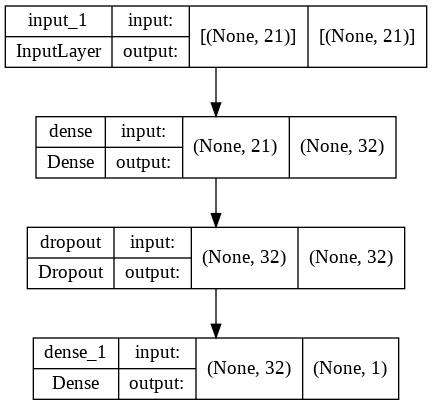

In [52]:
tf.keras.backend.clear_session()

def create_time_model(dense_units = 32, dr = .2 ):

    input_ = Input(shape=(21))
    x = dense_block(input_, dense_units, dr)
    out = Dense(1)(x)
    model = Model(inputs = input_, outputs = out)
    return model

model = create_time_model()
model.compile(loss = 'mape', optimizer = 'adam', metrics = ['mae', create_smape()])
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True)

In [53]:
early_stopping = EarlyStopping(patience = 10, restore_best_weights= True)
history = model.fit(x_train, y_train, epochs = 50, validation_data = [x_valid, y_valid], callbacks = early_stopping)

Epoch 1/50
900/900 [==============================] - 4s 4ms/step - loss: 2990.8667 - mae: 0.7545 - smape: 41.1447 - val_loss: 1003.8142 - val_mae: 0.6081 - val_smape: 39.8108
Epoch 2/50
900/900 [==============================] - 3s 4ms/step - loss: 3449.6724 - mae: 0.6481 - smape: 40.3192 - val_loss: 770.8657 - val_mae: 0.5852 - val_smape: 39.0982
Epoch 3/50
900/900 [==============================] - 4s 4ms/step - loss: 1898.1937 - mae: 0.5860 - smape: 38.9461 - val_loss: 786.8937 - val_mae: 0.5291 - val_smape: 37.1111
Epoch 4/50
900/900 [==============================] - 4s 4ms/step - loss: 2127.5715 - mae: 0.5276 - smape: 38.1631 - val_loss: 730.7545 - val_mae: 0.5181 - val_smape: 38.2715
Epoch 5/50
900/900 [==============================] - 4s 4ms/step - loss: 1565.5742 - mae: 0.5108 - smape: 37.8069 - val_loss: 621.0444 - val_mae: 0.4721 - val_smape: 34.5991
Epoch 6/50
900/900 [==============================] - 3s 4ms/step - loss: 2066.7834 - mae: 0.4873 - smape: 37.8087 - val_los

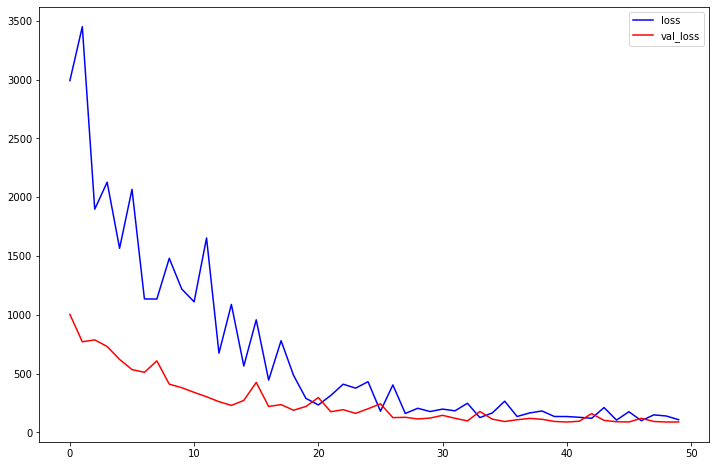

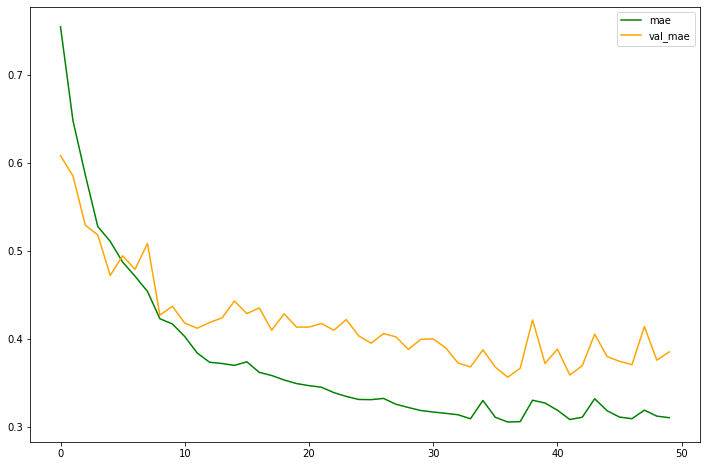

107/107 [==============================] - 0s 3ms/step - loss: 88.8447 - mae: 0.3853 - smape: 28.7032


[88.84468078613281, 0.38533324003219604, 28.70317840576172]

In [54]:
plot_model_perf(history, ['mae'])
y_pred = model.predict(x_valid)
model.evaluate(x_valid, y_valid)

In [55]:
def plot_predictions(data, dict_number, model = model):
  plt.figure(figsize = (20, 8))
  test_batch = data[dict_number].iloc[:,:-1]
  targets = data[dict_number].iloc[:,-1].values
  test_pred = model.predict(test_batch)
  vline = np.linspace(0, test_pred.shape[0], test_pred.shape[0])
  plt.plot(vline, test_pred.reshape(-1), color = 'red', label = 'Prediction')
  plt.plot(vline, targets.reshape(-1), color = 'green', label = 'Actual')
  plt.title(f'Prediction vs. actual for validation dataset {dict_number}')
  plt.xlabel("Week")
  plt.ylabel("Value")
  plt.legend()
  plt.show()

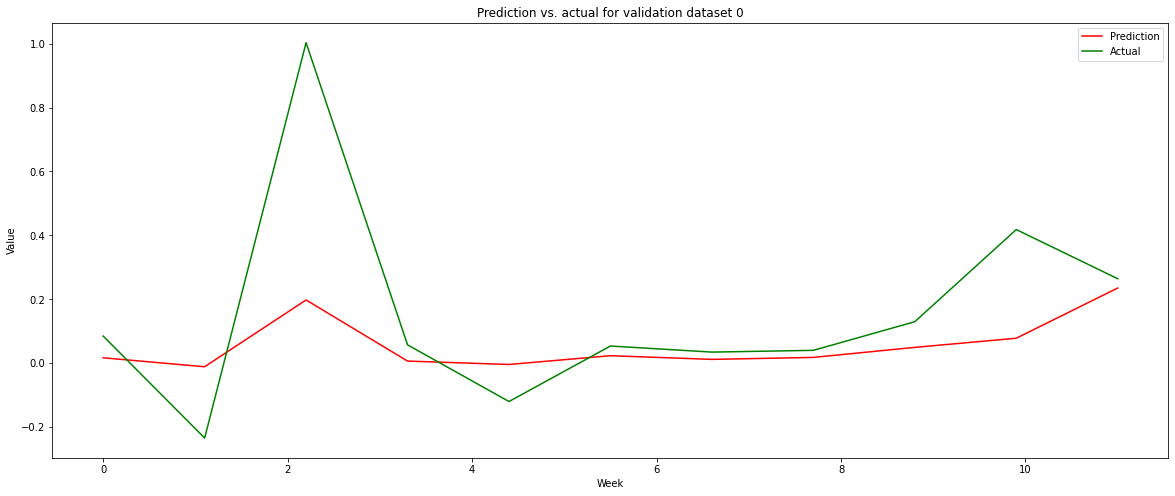

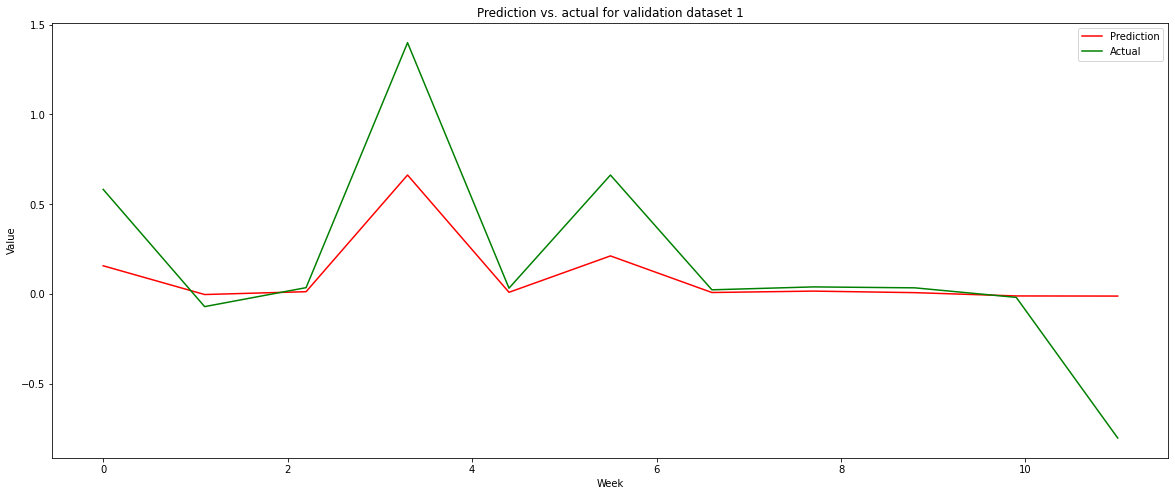

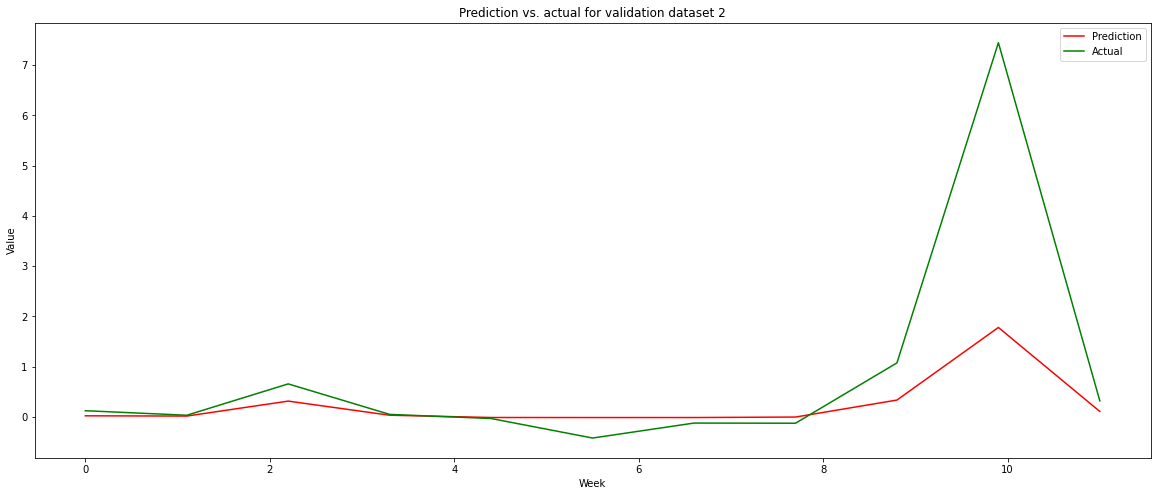

In [56]:
for i in range(0, 3):
  plot_predictions(valid_scaled, i)

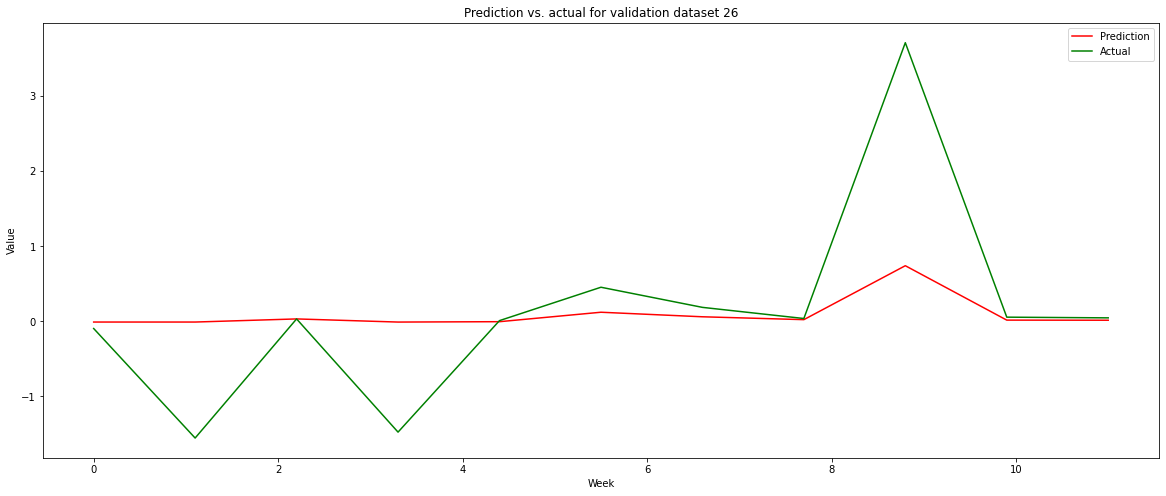

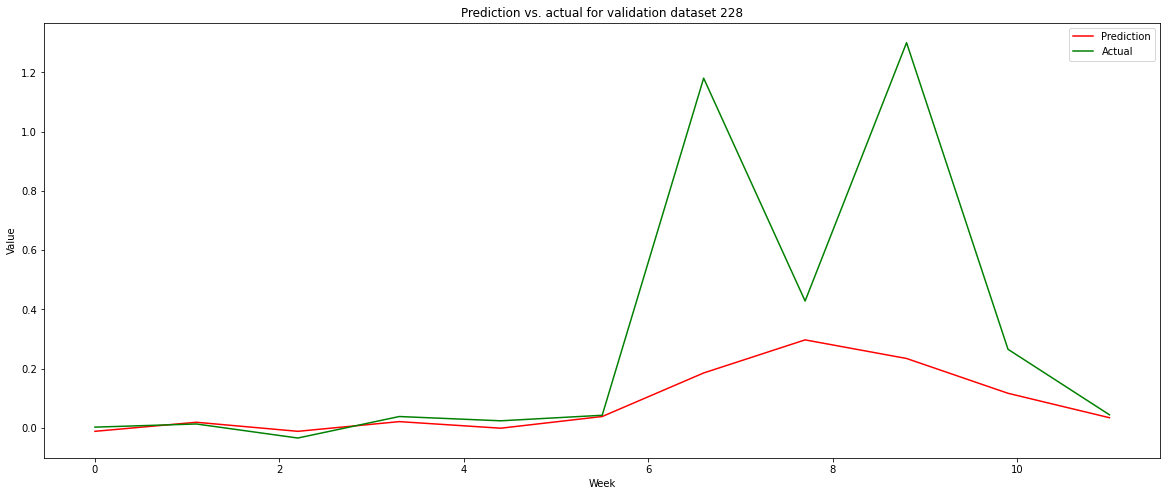

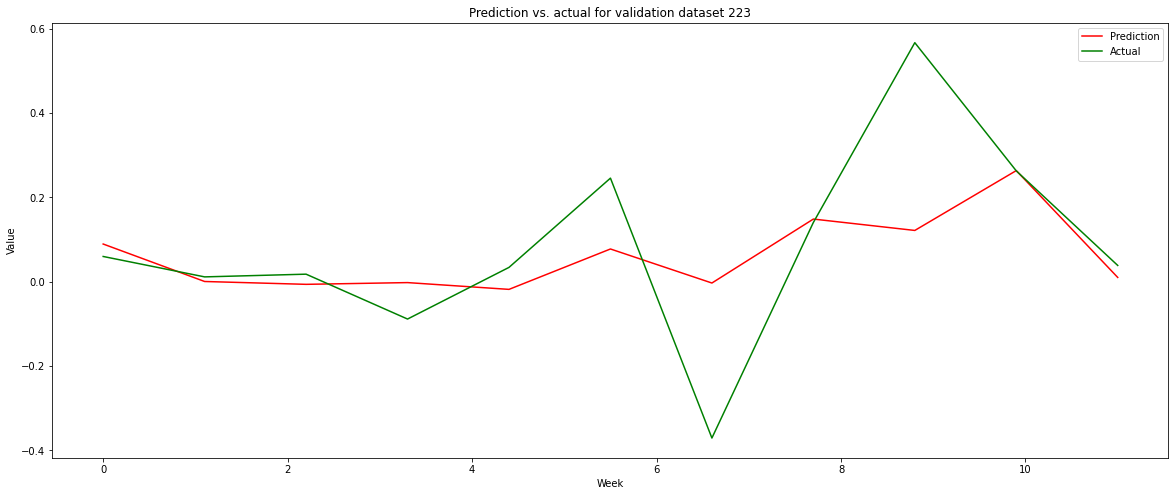

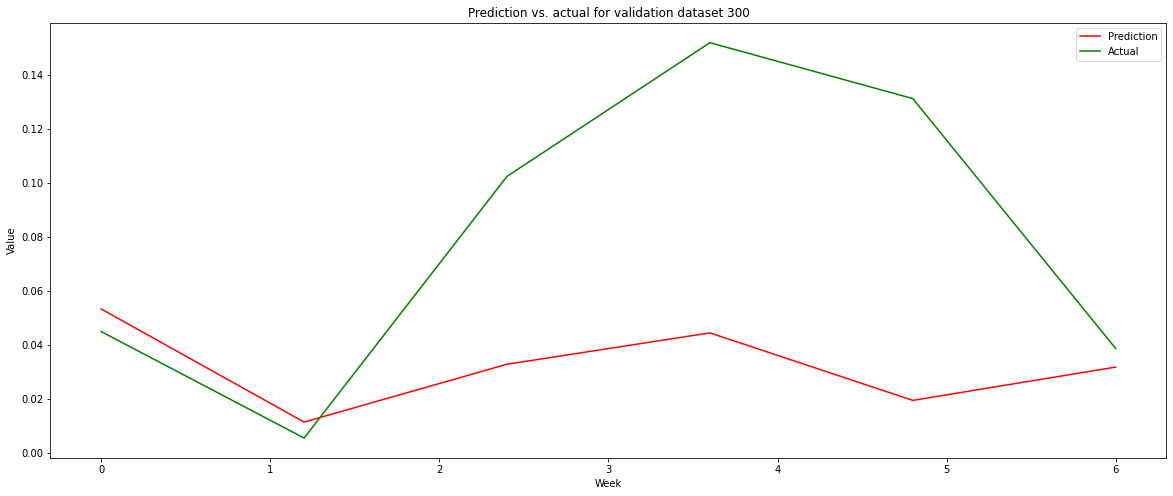

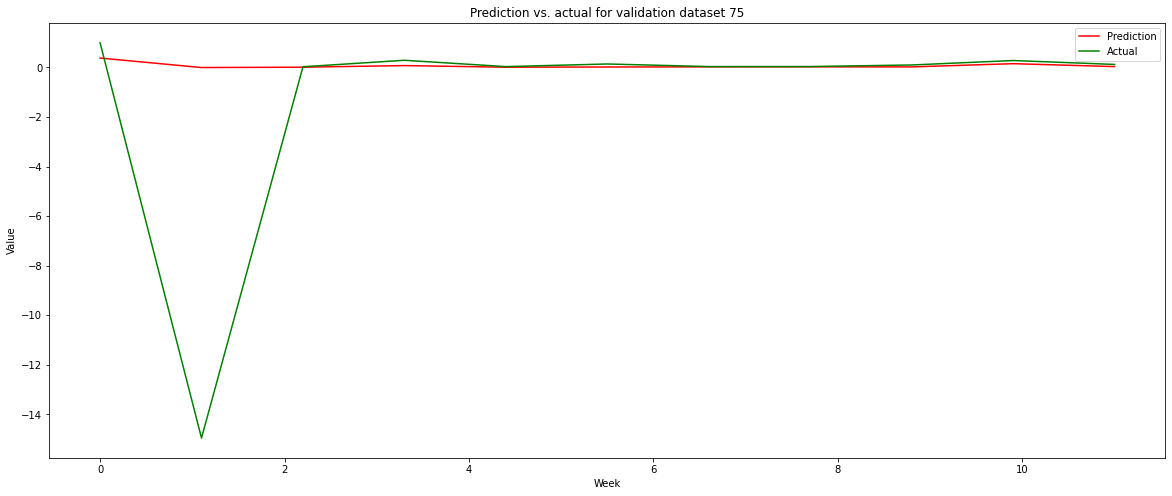

In [57]:
for i in range(0,5):
  plot_predictions(valid_scaled, np.random.randint(0, len(valid_scaled)))